In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchlake.image_generation.controllers.trainer_pixelcnn import PixelCNNTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.pixelcnn import PixelCNN
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/pixelcnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/cifar10")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.CIFAR10(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

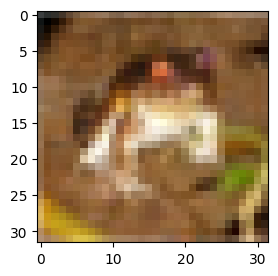

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]))

In [8]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE)

In [9]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [10]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 32, 32]) torch.Size([384, 32, 32])


# Model

In [11]:
model = PixelCNN(
    3,
    256,
    hidden_dim=128,
    num_layer=12,
)

In [12]:
import torchinfo

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PixelCNN                                 --
├─Sequential: 1-1                        --
│    └─MaskedConv2d: 2-1                 113,664
├─Sequential: 1-2                        --
│    └─ResBlock: 2-2                     --
│    │    └─ReLU: 3-1                    --
│    │    └─BottleNeck: 3-2              1,918,464
│    │    └─Identity: 3-3                --
│    └─ResBlock: 2-3                     --
│    │    └─ReLU: 3-4                    --
│    │    └─BottleNeck: 3-5              1,918,464
│    │    └─Identity: 3-6                --
│    └─ResBlock: 2-4                     --
│    │    └─ReLU: 3-7                    --
│    │    └─BottleNeck: 3-8              1,918,464
│    │    └─Identity: 3-9                --
│    └─ResBlock: 2-5                     --
│    │    └─ReLU: 3-10                   --
│    │    └─BottleNeck: 3-11             1,918,464
│    │    └─Identity: 3-12               --
│    └─ResBlock: 2-6                  

# train

In [13]:
EPOCH = 10

In [14]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [15]:
trainer.recorder.increment_data_size(len(train_data))

In [16]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
scaler = torch.amp.GradScaler()

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 390/390 [03:47<00:00,  1.71it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.4083e-02 (0.00%)


100%|██████████| 390/390 [03:51<00:00,  1.69it/s]


------------------------------------
Epoch 2
------------------------------------
total: 2.8595e-02 (-16.00%)


100%|██████████| 390/390 [03:47<00:00,  1.72it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.6343e-02 (-8.00%)


100%|██████████| 390/390 [03:45<00:00,  1.73it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.5596e-02 (-3.00%)


100%|██████████| 390/390 [03:48<00:00,  1.71it/s]


------------------------------------
Epoch 5
------------------------------------
total: 2.4840e-02 (-3.00%)


100%|██████████| 390/390 [03:46<00:00,  1.72it/s]


------------------------------------
Epoch 6
------------------------------------
total: 2.4209e-02 (-3.00%)


100%|██████████| 390/390 [03:47<00:00,  1.71it/s]


------------------------------------
Epoch 7
------------------------------------
total: 2.3989e-02 (-1.00%)


100%|██████████| 390/390 [03:58<00:00,  1.64it/s]


------------------------------------
Epoch 8
------------------------------------
total: 2.5004e-02 (4.00%)


100%|██████████| 390/390 [04:08<00:00,  1.57it/s]


------------------------------------
Epoch 9
------------------------------------
total: 2.3672e-02 (-5.00%)


100%|██████████| 390/390 [04:05<00:00,  1.59it/s]

------------------------------------
Epoch 10
------------------------------------
total: 2.3233e-02 (-2.00%)


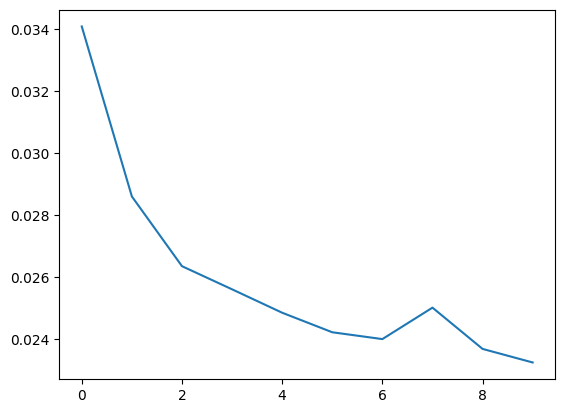

In [19]:
plt.plot(training_loss)

In [20]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelcnn.d{hidden_dim}.l{num_layer}.cifar10.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer)

In [21]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelcnn\pixelcnn.d128.l12.cifar10.pth, model size is 91.1MiB


In [22]:
manager.load_weight(model_path, model)

# evaluation

In [23]:
TEST_BATCH_SIZE = 16

3072it [01:06, 46.01it/s]


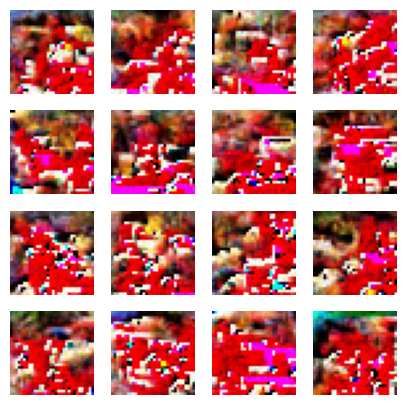

In [24]:
from itertools import product


model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(3))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder)[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    num_col=4,
    num_row=4,
    figsize=(5,5),
)